In [1]:
import pandas as pd
import numpy as np

In [2]:
# read file
news = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", index_col = 0)
news.head(3)

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN


In [3]:
news.groupby('type').size().sort_values(ascending = False)

type
fake          155
conspiracy     31
political      23
bias            6
junksci         6
unknown         6
unreliable      6
reliable        3
clickbait       1
hate            1
dtype: int64

In [4]:
# some contents may same, remove
news2 = news.drop_duplicates('content', 'first')
news2.groupby('type').size().sort_values(ascending = False)

type
fake          146
conspiracy     31
political      22
bias            6
unknown         6
unreliable      6
junksci         5
reliable        3
clickbait       1
hate            1
dtype: int64

In [5]:
# We interested only in 'id', 'type', 'content', 'title' and 'domain'
df = pd.DataFrame(news2, columns = ['id', 'type', 'content', 'title', 'domain'])
df.head(3)

,id,type,content,title,domain
0,141,unreliable,Sometimes the power of Christmas will make you...,Church Congregation Brings Gift to Waitresses ...,awm.com
1,256,fake,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,beforeitsnews.com
2,700,unreliable,Never Hike Alone: A Friday the 13th Fan Film U...,Never Hike Alone - A Friday the 13th Fan Film ...,cnnnext.com


In [6]:
df.isnull().sum()

id          0
type       12
content     0
title       0
domain      0
dtype: int64

In [7]:
# remove NaN
df = df.dropna()

Text(0.5, 1.0, 'Number of articles by type')

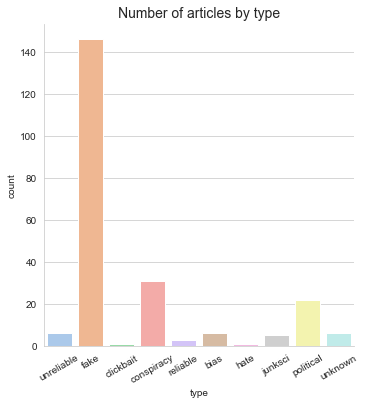

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette('pastel')
type_plot = sns.catplot('type', data = df, kind = 'count')
(type_plot.set_xticklabels(rotation=30)
          .ax.set_title('Number of articles by type', fontsize = 14)
          )

In [9]:
# Some types of samples are insufficient, merge labels
# df['type'].replace(
    # ['conspiracy', 'junksci', 'rumor', 'hate', 'unreliable', 'fake'], 'fake', inplace = True)
#df['type'].replace(['reliable'], 'truth', inplace = True)
df['type'].replace(['conspiracy', 'junksci', 'rumor', 'hate', 'unreliable', 'clickbait', 'unknown', 'satire', 'bias', 'political'], 'others', inplace = True)

Text(0.5, 1.0, 'Number of articles by merged type')

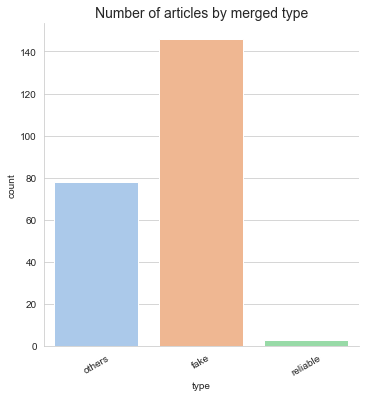

In [10]:
type_plot2 = sns.catplot('type', data = df, kind = 'count', )
(type_plot2.set_xticklabels(rotation=30)
          .ax.set_title('Number of articles by merged type', fontsize = 14)
          )

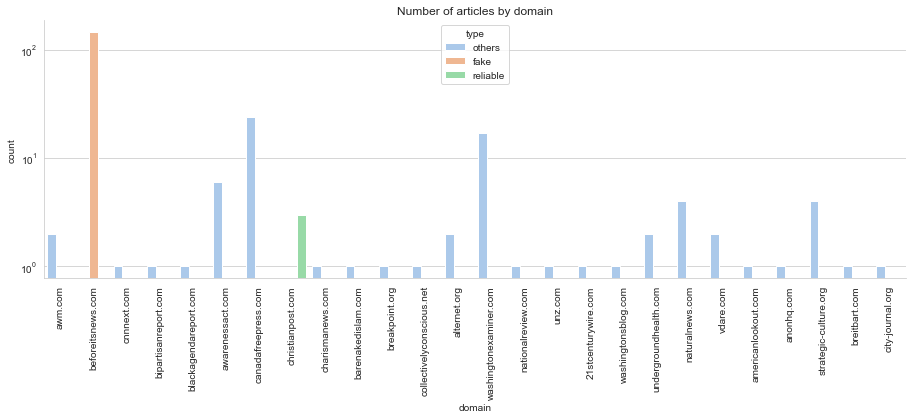

In [11]:
domain_plot = sns.catplot(x="domain", hue="type", data=df, kind="count", legend_out=False)
(domain_plot.set_xticklabels(rotation = 90)
            .set(yscale = 'log', title = 'Number of articles by domain')
            .fig.set_size_inches(15,4))

In [12]:
import re
import nltk

In [13]:
# define regexp for date
monthsShort = "Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec"
monthsLong = "January|February|March|April|May|June|July|August|September|October|November|December"
months = "(" + monthsShort + "|" + monthsLong + ")"
separators = "[-/\s,.]"
days = "\d{2}"
years = "\d{4}"
regex1 = "(" + months + separators + days + "|" + years + ")"
regex2 = "(" + days + separators + months + "|" + years + ")"
regex3 = '^([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|\/)([1-9]|0[1-9]|1[0-2])(\.|-|\/)([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])$|^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|\/)([1-9]|0[1-9]|1[0-2])(\.|-|\/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$'

def my_clean_text(text):
    text = re.sub(r'\s+', ' ', text).lower() #replace multiple \s to single space and lower the text
    text = re.sub(r'^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$', ' <EMAIL> ', text) #Replace email to <EMAIL>
    text = re.sub(r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', ' <URL> ', text) #Replace URLs to <URL>
    text = re.sub(regex1, ' <DATE> ', text); text = re.sub(regex2, ' <DATE> ', text); text = re.sub(regex3, ' <DATE> ', text) #Replace date to <DATE>
    text = re.sub(r'[\d+,?]\.?\d*', ' <NUM> ', text) #replace any numbers to <NUM>
    text = re.sub(r'[^\w\s>]+\s|\s+[^\w\s<]', ' ', text) #remove sign at start or end of the words
    text = re.sub(r'[^\w\s\-<>\']', '', text) #remove in-words sign expect -,<,> and '
    text = re.sub(r'\s+', ' ', text) #replace multiple \s to single space again
    #text = re.sub(r'["”“@()*|\'#!≥+.,$€%&"]', ' ', text) #remove spical char
    return text

# clean text
df2 = df.copy(deep=True)
df2['content'] = df2.apply(lambda x: my_clean_text(x['content']), axis=1)
df2['title'] = df2.apply(lambda x: my_clean_text(x['title']), axis=1)

In [14]:
# Tokenize
from nltk.tokenize import RegexpTokenizer
def tok(text):
    tokenizer = RegexpTokenizer('\S+')
    tokens = tokenizer.tokenize(text)
    voc = [i for i in tokens]# if i.isalpha()]
    return voc

df4 = df2.copy(deep=True)
# tokenize contents
df4['content'] = df4.apply(lambda x: tok(x['content']), axis=1)
# tokenize title
df4['title'] = df4.apply(lambda x: tok(x['title']), axis=1)

In [15]:
# count URLs dates and num in content
df4_1 = df4.explode('content').reset_index(drop=True)
count = pd.crosstab(df4_1.type,df4_1.content)

print('counte the number of URLs in fake, other, truth : ', count.loc['fake']['<URL>'], count.loc['others']['<URL>'], count.loc['reliable']['<URL>'])
print('counte the number of dates in fake, other, truth: ', count.loc['fake']['<DATE>'], count.loc['others']['<DATE>'], count.loc['reliable']['<DATE>'])
print('counte the number of numeric values fake, other, truth: ', count.loc['fake']['<NUM>'], count.loc['others']['<NUM>'], count.loc['reliable']['<NUM>'])

counte the number of URLs in fake, other, truth :  624 211 3
counte the number of dates in fake, other, truth:  472 226 4
counte the number of numeric values fake, other, truth:  6553 3980 102


In [16]:
# only keep words
df4_2 = df4.copy(deep=True)
df4_2['content'] = df4_2.apply(lambda x: [i for i in x['content'] if i.isalpha()], axis=1)
df4_2['title'] = df4_2.apply(lambda x: [i for i in x['title'] if i.isalpha()], axis=1)
# word count
df4_2['len_content'] = df4_2.apply(lambda x: len(x['content']), axis=1)
df4_2['len_title'] = df4_2.apply(lambda x: len(x['title']), axis=1)

Text(0.5, 1.0, 'Word count of different types for contents')

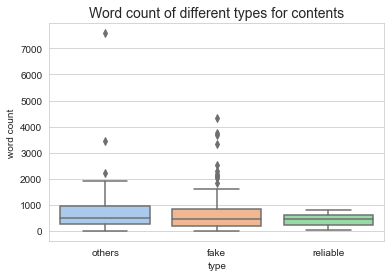

In [17]:
box1 = sns.boxplot(x=df4_2['type'], y=df4_2['len_content'])
box1.set(ylabel='word count')
box1.set_title('Word count of different types for contents', fontsize = 14)

Text(0.5, 1.0, 'Word count of different types for contents')

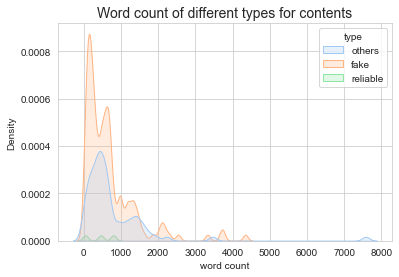

In [18]:
dis1 = sns.kdeplot(data = df4_2, x="len_content", hue = 'type', bw_adjust=.25, fill=True)
dis1.set(xlabel='word count')
dis1.set_title('Word count of different types for contents', fontsize = 14)

Text(0.5, 1.0, 'Word count of different types for titles')

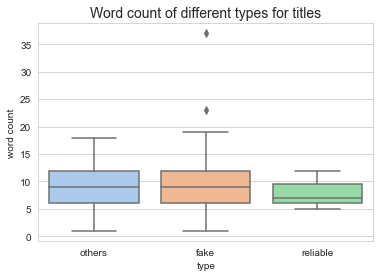

In [19]:
box2 = sns.boxplot(x=df4_2['type'], y=df4_2['len_title'])
box2.set(ylabel='word count')
box2.set_title('Word count of different types for titles', fontsize = 14)

Text(0.5, 1.0, 'Word count of different types for titles')

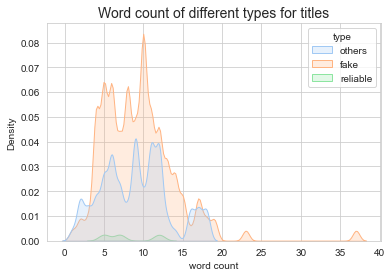

In [20]:
dis2 = sns.kdeplot(data = df4_2, x="len_title", hue = 'type', bw_adjust=.25, fill=True)
dis2.set(xlabel='word count')
dis2.set_title('Word count of different types for titles', fontsize = 14)

In [21]:
# Remove stopwords
df5 = df4_2.copy(deep=True)
from nltk.corpus import stopwords 
stop = set(stopwords.words('english'))
df5['content'] = df5.apply(lambda x: ([w for w in x['content'] if w not in stopwords.words('english')]), axis=1)
df5['len_content'] = df5.apply(lambda x: len(x['content']), axis=1)
df5['title'] = df5.apply(lambda x: ([w for w in x['title'] if w not in stopwords.words('english')]), axis=1)
df5['len_title'] = df5.apply(lambda x: len(x['title']), axis=1)

In [22]:
# reduction rate
def rr(data):
    expened_df = data.explode('content').reset_index(drop=True)
    expened_df_tok = df4_2.explode('content').reset_index(drop=True)
    rr = (expened_df_tok.shape[0] - expened_df.shape[0]) / expened_df_tok.shape[0]
    return rr
print('reduction rate of contents after removing stopwords :', rr(df5))

reduction rate of contents after removing stopwords : 0.44381021450587377


In [23]:
# stemming
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
df6 = df5.copy(deep=True)  
df6['content'] = df6.apply(lambda x: ([WordNetLemmatizer().lemmatize(i) for i in x['content']]), axis=1)
df6['title'] = df6.apply(lambda x: ([WordNetLemmatizer().lemmatize(i) for i in x['title']]), axis=1)
df6['len_content'] = df6.apply(lambda x: len(x['content']), axis=1)
df6['len_title'] = df6.apply(lambda x: len(x['title']), axis=1)

# reduction reat
print('reduction rate of contents after stemming:', rr(df6))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
reduction rate of contents after stemming: 0.44381021450587377


In [24]:
# word frequency
# without removing stopwords and stemming
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df4_3 = df4_2.copy(deep=True)
df4_3 = df4_3.drop(columns=['id', 'title', 'domain', 'len_content',"len_title"])
df4_3 = df4_3.explode('content').reset_index(drop=True)
df4_3[['content', 'type']].groupby(['content']).size().nlargest(100).reset_index(name='top100')

,content,top100
0,the,9130
1,of,4783
2,to,4735
3,and,4533
4,a,3269
5,in,2993
6,is,2257
7,that,2137
8,for,1506
9,it,1311


In [25]:
# word frequency
# with removing stopwords and stemming
df6_1 = df6.copy(deep=True)
df6_1 = df6_1.drop(columns=['id', 'title', 'domain', 'len_content',"len_title"])
df6_1 = df6_1.explode('content').reset_index(drop=True)
df6_1[['content', 'type']].groupby(['content']).size().nlargest(100).reset_index(name='top100')

,content,top100
0,one,449
1,people,374
2,time,369
3,like,325
4,trump,319
5,state,312
6,would,311
7,year,285
8,market,276
9,u,276


In [26]:
# Extract the digits in contents
df7 = df.copy(deep=True)
df7['dig_in_content'] = df7.apply(lambda x: re.sub(r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', '', x['content']), axis=1)
df7['dig_in_content'] = df7.apply(lambda x: re.findall(r'\d+\.?\d*',x['dig_in_content']), axis=1)
df8 = df7.copy(deep=True)
df8 = df8.explode('dig_in_content').reset_index(drop=True)
df8 = df8.dropna()
df8['dig_in_content'] = df8['dig_in_content'].astype(float)
df8.groupby('type')['dig_in_content'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
fake,1596.0,1583.602130,15462.682027,0.0,8.0,40.0,1978.0,411001.0
others,787.0,623.950445,890.367591,0.0,12.0,40.0,1950.5,5000.0
reliable,21.0,397.047619,799.932089,0.0,4.0,10.0,60.0,2018.0


Text(0.5, 1.0, 'digits of different types for titles')

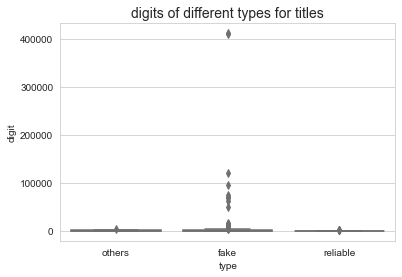

In [27]:
box3 = sns.boxplot(x=df8['type'], y=df8['dig_in_content'])
box3.set(ylabel='digit')
box3.set_title('digits of different types for titles', fontsize = 14)

In [28]:
from matplotlib.cbook import boxplot_stats   
np.sort(boxplot_stats(df8['dig_in_content']).pop(0)['fliers'])

array([  5000.,   5000.,   5000.,   5195.,   5441.,   5441.,   7241.,
         7241.,   7419.,   8507.,   9126.,   9126.,   9674.,   9750.,
        10951.,  11051.,  11051.,  12881.,  13526.,  13642.,  17304.,
        49827.,  61401.,  69200.,  71362.,  75252.,  95640., 120000.,
       409020., 411001.])

In [29]:
#remove outlierss and big numbers(address, zipcode...)
df9 = df8.drop(df8[df8['dig_in_content'] > 12000].index)
df9.groupby('type')['dig_in_content'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
fake,1583.0,699.540745,1175.531402,0.0,8.0,38.0,1969.5,11051.0
others,787.0,623.950445,890.367591,0.0,12.0,40.0,1950.5,5000.0
reliable,21.0,397.047619,799.932089,0.0,4.0,10.0,60.0,2018.0


Text(0.5, 1.0, 'digits of different types for contents, remove some outliers')

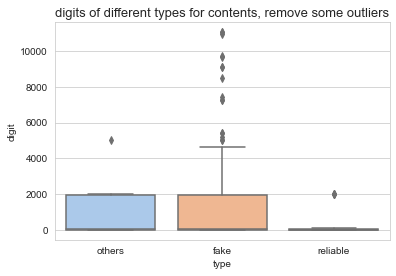

In [30]:
box4 = sns.boxplot(x=df9['type'], y=df9['dig_in_content'])
box4.set(ylabel='digit')
box4.set_title('digits of different types for contents, remove some outliers', fontsize = 13)

Text(0.5, 1.0, 'digits of different types for contents')

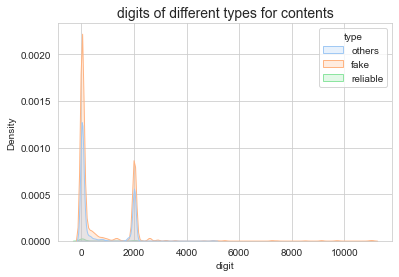

In [31]:
dis3 = sns.kdeplot(data = df9, x="dig_in_content", hue = 'type', bw_adjust=.25, fill=True)
dis3.set(xlabel='digit')
dis3.set_title('digits of different types for contents', fontsize = 14)

Text(0.5, 1.0, 'digits of different types for contents, cut off at 3500')

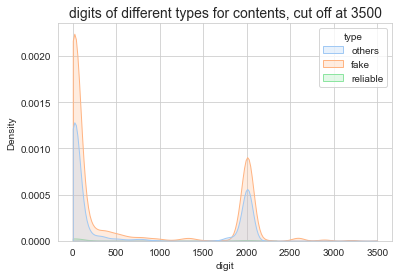

In [32]:
dis4 = sns.kdeplot(data = df9, hue = 'type', x="dig_in_content", bw_adjust=.25, fill=True, clip=(0,3500))
dis4.set(xlabel='digit')
dis4.set_title('digits of different types for contents, cut off at 3500', fontsize = 14)

In [33]:
#import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')

In [34]:
df10 = df4_2.explode('content').reset_index(drop=True)
df11 = df10.drop(columns=['id', 'title', 'domain', 'len_content','len_title'])
def my_merge(df):
    return','.join(df.values)
df11 = df11.groupby(['type'])['content'].apply(my_merge)
df11 = df11.reset_index()

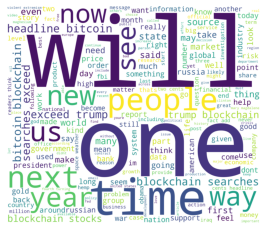

In [37]:
# word cloud by type
from wordcloud import WordCloud
# fake
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df11['content'][0])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

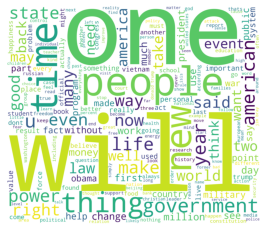

In [38]:
# others
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df11['content'][1])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

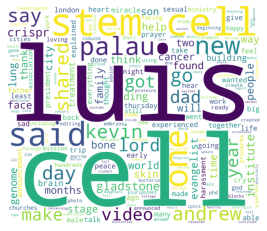

In [39]:
# reliable
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df11['content'][2])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [40]:
# after removing stopwords
df12 = df5.explode('content').reset_index(drop=True)
df13 = df12.drop(columns=['id', 'title', 'domain', 'len_title', 'len_content'])
def my_merge(df):
    return','.join(df.values)
df13 = df13.groupby(['type'])['content'].apply(my_merge)
df13 = df13.reset_index()

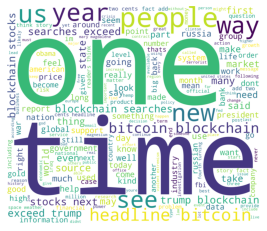

In [41]:
# fake
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df13['content'][0])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

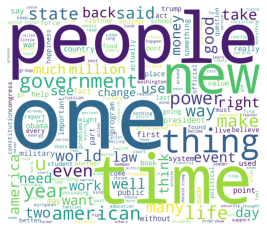

In [42]:
# others
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df13['content'][1])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

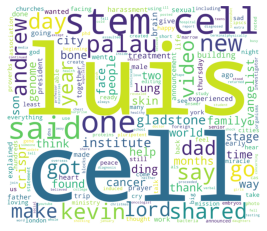

In [43]:
# reliable
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate(df13['content'][2])
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.show()